# Building simulation of Lennard-Jones potential and force for pairwise interactions 

- We work in reduced Lennard–Jones (LJ) units: σ = 1, ε= 1, m= 1. The LJ time unit is τ = σ m/ε; we use a fixed time step dt= 0.005 τ.
- Initialise N = 10 particles uniformly in a cubic box of side L = 5 (reduced units). For this minimal example, periodic boundaries are not used.
- Pair interactions are truncated at rc = 2.5 (standard LJ cutoff) with no tail corrections.
- Velocities are drawn from a zero-mean normal distribution; remove the centre-of mass momentum.
- Integrate with velocity–Verlet and monitor total energy. With these settings, energy should be approximately conserved and positions will evolve perceptibly.

In [82]:
import numpy as np
def U_LJ(r):
 return 4 * ((1/r)**12 - (1/r)**6) # Reduced LJ potential u*(r*)
def F_LJ(r):
 return 24 * (2*(1/r)**12 - (1/r)**6) / r # Reduced LJ force magnitude f*(r*)



## Initialising the system 
Independent variables

Current position → compute forces



In [83]:
N = 10 # number of particles
L = 5.0 # box length (in reduced LJ units)
dt = 0.014 # reduced time step (dt* = 0.005)
nsteps = 2000 # number of integration steps
np.random.seed(1)
positions = np.random.rand(N, 3) * L # uniform initial positions,, start within that space 
velocities = np.random.randn(N, 3) # random velocities (normal distribution)


# Remove any net drift of the entire system. Without this, the whole group of particles might move in one direction.
velocities -= velocities.mean(axis=0) # remove centre-of-mass drift 


rc = 2.5 # reduced cutoff (no tail corrections)
def compute_forces(positions, rc=rc):
    N = positions.shape[0]
    forces = np.zeros_like(positions)
    potential = 0.0
    for i in range(N - 1):
        for j in range(i + 1, N):
            rij = positions[i] - positions[j]
            r = np.linalg.norm(rij)
    
        # skip self/near-zero distances to avoid division by zero
            if r < 1e-12:
                continue
    
            if r < rc:
                fij_mag = F_LJ(r) # reduced LJ force magnitude
                fij_vec = fij_mag * (rij / r)
                forces[i] += fij_vec
                forces[j] -= fij_vec
                potential += U_LJ(r) # reduced pair potential
        
    return forces, potential

## Integrating Loop (Velocity Verlet)

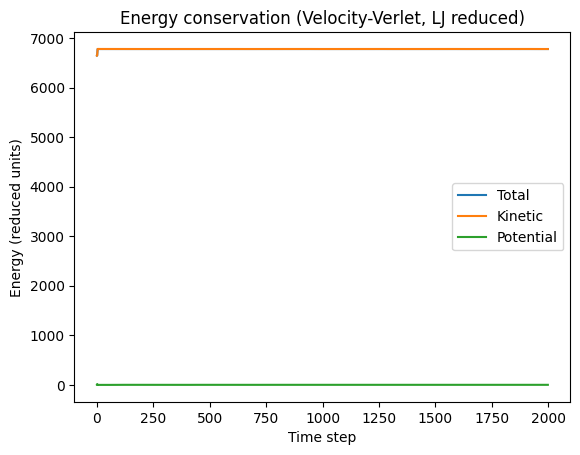

Text(0, 0.5, 'Potential Energy (reduced units)')

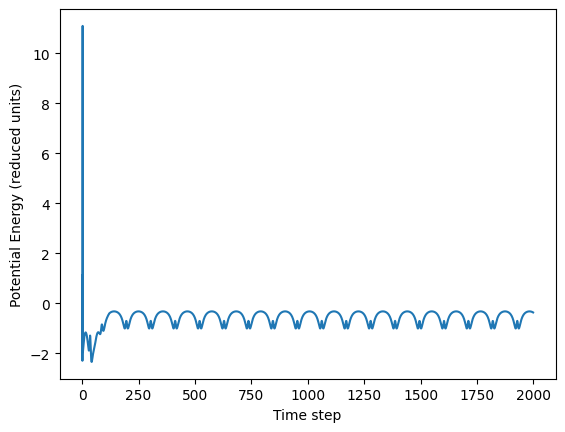

In [84]:
import matplotlib.pyplot as plt

# initial forces and potential
forces, pot = compute_forces(positions)

KE, PE, TE = [], [], []
save_stride = 10
traj = [] # list of snapshots for XYZ export


for step in range(nsteps):
    # Velocity-Verlet (m* = 1 => no division by mass)
    velocities += 0.5 * forces * dt
    positions += velocities * dt
    forces, pot = compute_forces(positions)
    velocities += 0.5 * forces * dt

    # energies in reduced units
    kin = 0.5 * np.sum(velocities**2) # m* = 1
    KE.append(kin); PE.append(pot); TE.append(kin + pot)

    if step % save_stride == 0: 
        traj.append(positions.copy()) # avoid aliasing
        
        
# ---- plot energies (reduced units) ----
plt.plot(TE, label='Total')
plt.plot(KE, label='Kinetic')
plt.plot(PE, label='Potential')
plt.xlabel('Time step')
plt.ylabel('Energy (reduced units)')
plt.title('Energy conservation (Velocity-Verlet, LJ reduced)')
plt.legend()
plt.show()



plt.plot(PE, label='Potential')
plt.xlabel('Time step')
plt.ylabel('Potential Energy (reduced units)')


## Exporting a Trajectory 

In [85]:
with open("traj.xyz", "w") as f:
    for k, frame in enumerate(traj):
        step = k * save_stride
        f.write(f"{N}\nStep {step} (LJ reduced units, box L={L})\n")
        for x, y, z in frame:
            f.write(f"Ar {x:.6f} {y:.6f} {z:.6f}\n")
            